In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker
from matplotlib import font_manager
import numpy as np
from scipy.optimize import curve_fit
import os
from datetime import datetime

#%% FORMATO GRAFICAS
def formato_grafico(ax=None, decimalx=None, decimaly=None, legend_loc='upper right'):
    if ax is None:
        ax = plt.gca()

    fuente = 'sans'
    ax.title.set_size(14)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    ax.title.set_family(fuente)
    ax.yaxis.label.set_family(fuente)
    ax.xaxis.label.set_family(fuente)
    ax.tick_params(axis='both', labelsize=14)

    plt.rcParams['mathtext.fontset'] = 'cm'  
    plt.rcParams['mathtext.rm'] = 'sans'  
    plt.rcParams['mathtext.default'] = 'rm'

    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

    ax.tick_params(axis='x', direction='in', which='both', bottom=True, top=True)
    ax.tick_params(axis='y', direction='in', which='both', left=True, right=True)
    ax.tick_params(axis='x', which='minor', direction='in', bottom=True, top=True)
    ax.tick_params(axis='y', which='minor', direction='in', left=True, right=True)

    if decimalx is not None:
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.{decimalx}f}' if x != 0 else '0'))
    if decimaly is not None:
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.{decimaly}f}' if x != 0 else '0'))

    if ax.get_legend() is not None:
        ax.legend(fontsize=16)

    font = font_manager.FontProperties(family='sans', style='normal', size=16)
    handles, labels = ax.get_legend_handles_labels()
    if handles and labels:
        ax.legend(loc=legend_loc, handles=handles, labels=labels,
                  edgecolor='1', framealpha=0.5, prop=font)

#%% FUNCIONES GAUSSIANA Y AJUSTES
def gauss(x, A, B, C, mu, sigma):
    return A + B * (x - mu) + C * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

def gauss_ajuste(x, y):
    media = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - media) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[1, 1, min(y), media, sigma])
    return popt, pcov

def Ajuste_gaussiano(canal, cuentas, extremo_inferior, extremo_superior,
                     a_0=0, a_1=1, unidades='canal', titulo='Ajuste Gaussiano', ylim=None):
    x = canal[extremo_inferior:extremo_superior]
    y = cuentas[extremo_inferior:extremo_superior]
    x = x * a_1 + a_0

    popt, pcov = gauss_ajuste(x, y)
    A, B, C, mu, sigma = popt

    x_ajuste = np.linspace(extremo_inferior, extremo_superior, 100) * a_1 + a_0
    y_ajuste = gauss(x_ajuste, A, B, C, mu, sigma)
    recta_ajuste = A + B * (x_ajuste - mu)

    FWHM = 2.35482 * sigma
    uncertainties = np.sqrt(np.diag(pcov))

    print("\nPico:     ", titulo)
    print("b0:        {:.0f} ± {:.0f}".format(A, uncertainties[0]))
    print("b1:        {:.3f} ± {:.3f}".format(B, uncertainties[1]))
    print("M:         {:.0f} ± {:.0f}".format(C, uncertainties[2]))
    print("μ:         {:.2f} ± {:.2f}".format(mu, uncertainties[3]))
    print("σ:         {:.2f} ± {:.2f}".format(abs(sigma), abs(uncertainties[4])))
    print("FWHM:      {:.2f} ± {:.2f}".format(abs(FWHM), abs(FWHM * (uncertainties[4] / sigma))))

    I = abs((2 * np.pi) ** 0.5 * C * sigma)
    dI = I*np.sqrt((uncertainties[2]/C)**2 + (uncertainties[4]/sigma)**2)
    print("Intensidad:      {:.0f} ± {:.0f}".format(abs(I), abs(dI)))

    plt.figure(figsize=(10, 5))
    plt.step(x, y, 'k', label='{}'.format(titulo), where='mid')
    plt.plot(x_ajuste, y_ajuste, '--r', linewidth=2,
             label=r'$b_0 + b_1 (x - \mu) + M \exp \left[-\frac{(x-\mu)^2}{2\sigma^2} \right]$')
    plt.plot(x_ajuste, recta_ajuste, '--b', linewidth=2,
             label=r'$b_0 + b_1 (x - \mu) $')
    plt.grid()
    plt.title("")
    plt.ylabel(r'$I_{\gamma}$' + ' [cuentas / canal]')
    if unidades == 'canal':
        plt.xlabel(r'canal')
    elif unidades == 'keV':
        plt.xlabel(r'$E_{\gamma}$' + ' (keV)')
    if ylim:
        plt.ylim(ylim)

    formato_grafico()
    plt.tight_layout()

    # Guardar la imagen
    save_path = r"Parcial"
    filename = f"Practica2_{titulo.replace(' ', '_')}.png"
    full_path = os.path.join(save_path, filename)
    plt.savefig(full_path, dpi=300, bbox_inches='tight')
    plt.show()

# Doble gauss
def double_gauss(x, A, B, C1, mu1, sigma1, C2, mu2, sigma2):
    return (A + B * (x - mu1) +
            C1 * np.exp(-((x - mu1) ** 2) / (2 * sigma1 ** 2)) +
            C2 * np.exp(-((x - mu2) ** 2) / (2 * sigma2 ** 2)))

def double_gauss_ajuste(x, y):
    media = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - media) ** 2) / sum(y))
    p0 = [1, 1, max(y), media - sigma, sigma, max(y)/2, media + sigma, sigma]
    popt, pcov = curve_fit(double_gauss, x, y, p0=p0)
    return popt, pcov

def Ajuste_doble_gaussiano(canal, cuentas, extremo_inferior, extremo_superior,
                           a_0=0, a_1=1, unidades='canal', titulo='Ajuste Doble Gaussiano', ylim=None):
    x = canal[extremo_inferior:extremo_superior]
    y = cuentas[extremo_inferior:extremo_superior]
    x = x * a_1 + a_0

    popt, pcov = double_gauss_ajuste(x, y)
    A, B, C1, mu1, sigma1, C2, mu2, sigma2 = popt

    x_ajuste = np.linspace(extremo_inferior, extremo_superior, 100) * a_1 + a_0
    y_ajuste = double_gauss(x_ajuste, *popt)
    recta_ajuste = A + B * (x_ajuste - mu1)

    FWHM1 = 2.35482 * sigma1
    FWHM2 = 2.35482 * sigma2
    uncertainties = np.sqrt(np.diag(pcov))

    print("\nPico:     ", titulo)
    print("b0:        {:.0f} ± {:.0f}".format(A, uncertainties[0]))
    print("b1:        {:.3f} ± {:.3f}".format(B, uncertainties[1]))
    print("M1:        {:.0f} ± {:.0f}".format(C1, uncertainties[2]))
    print("μ1:        {:.2f} ± {:.2f}".format(mu1, uncertainties[3]))
    print("σ1:        {:.2f} ± {:.2f}".format(abs(sigma1), abs(uncertainties[4])))
    print("FWHM1:     {:.2f} ± {:.2f}".format(abs(FWHM1), abs(FWHM1 * (uncertainties[4] / sigma1))))
    print("M2:        {:.0f} ± {:.0f}".format(C2, uncertainties[5]))
    print("μ2:        {:.2f} ± {:.2f}".format(mu2, uncertainties[6]))
    print("σ2:        {:.2f} ± {:.2f}".format(abs(sigma2), abs(uncertainties[7])))
    print("FWHM2:     {:.2f} ± {:.2f}".format(abs(FWHM2), abs(FWHM2 * (uncertainties[7] / sigma2))))

    I1 = abs((2 * np.pi) ** 0.5 * C1 * sigma1)
    dI1 = I1 * np.sqrt((uncertainties[2]/C1)**2 + (uncertainties[4]/sigma1)**2)
    I2 = abs((2 * np.pi) ** 0.5 * C2 * sigma2)
    dI2 = I2 * np.sqrt((uncertainties[5]/C2)**2 + (uncertainties[7]/sigma2)**2)

    print("Intensidad1:      {:.0f} ± {:.0f}".format(abs(I1), abs(dI1)))
    print("Intensidad2:      {:.0f} ± {:.0f}".format(abs(I2), abs(dI2)))
    print("IntensidadT:      {:.0f} ± {:.0f}".format(abs(I1+I2), abs(dI1+dI2)))

    plt.figure(figsize=(10, 5))
    plt.step(x, y, 'k', label='{}'.format(titulo), where='mid')
    plt.plot(x_ajuste, y_ajuste, '--r', linewidth=2,
             label=(r'$b_0 + b_1 (x - \mu) + M_1 e^{-\frac{(x-\mu_1)^2}{2\sigma_1^2}} + '
                    r'M_2 e^{-\frac{(x-\mu_2)^2}{2\sigma_2^2}}$'))
    plt.plot(x_ajuste, recta_ajuste, '--b', linewidth=2,
             label=r'$b_0 + b_1 (x - \mu_1) $')
    plt.grid()
    plt.ylabel(r'$I_{\gamma}$' + ' [cuentas / canal]')
    if unidades == 'canal':
        plt.xlabel(r'canal')
    elif unidades == 'keV':
        plt.xlabel(r'$E_{\gamma}$ [keV]')
    if ylim:
        plt.ylim(ylim)

    formato_grafico()
    plt.tight_layout()

    # Guardar la imagen
    save_path = r"Parcial"
    filename = f"Practica2_{titulo.replace(' ', '_')}.png"
    full_path = os.path.join(save_path, filename)
    plt.savefig(full_path, dpi=300, bbox_inches='tight')
    plt.show()

# Triple gauss
def triple_gauss(x, A, B, C1, mu1, sigma1, C2, mu2, sigma2, C3, mu3, sigma3):
    return (A + B * (x - mu1) +
            C1 * np.exp(-((x - mu1) ** 2) / (2 * sigma1 ** 2)) +
            C2 * np.exp(-((x - mu2) ** 2) / (2 * sigma2 ** 2)) +
            C3 * np.exp(-((x - mu3) ** 2) / (2 * sigma3 ** 2)))

def triple_gauss_ajuste(x, y, mu1, mu2, mu3):
    sigma = np.sqrt(sum(y * (x - mu1) ** 2) / sum(y))
    p0 = [1, 1, max(y), mu1, sigma, max(y)/2, mu2, sigma, max(y)/3, mu3, sigma]
    popt, pcov = curve_fit(triple_gauss, x, y, p0=p0)
    return popt, pcov

def Ajuste_triple_gaussiano(canal, cuentas, extremo_inferior, extremo_superior,
                            mu1, mu2, mu3, a_0=0, a_1=1, unidades='canal',
                            titulo='Ajuste Triple Gaussiano', ylim=None):
    x = canal[extremo_inferior:extremo_superior]
    y = cuentas[extremo_inferior:extremo_superior]
    x = x * a_1 + a_0

    popt, pcov = triple_gauss_ajuste(x, y, mu1, mu2, mu3)
    A, B, C1, mu1, sigma1, C2, mu2, sigma2, C3, mu3, sigma3 = popt

    x_ajuste = np.linspace(extremo_inferior, extremo_superior, 100) * a_1 + a_0
    y_ajuste = triple_gauss(x_ajuste, *popt)
    recta_ajuste = A + B * (x_ajuste - mu1)

    FWHM1 = 2.35482 * sigma1
    FWHM2 = 2.35482 * sigma2
    FWHM3 = 2.35482 * sigma3
    uncertainties = np.sqrt(np.diag(pcov))

    print(f"\nPico: {titulo}")
    print("b0:        {:.0f} ± {:.0f}".format(A, uncertainties[0]))
    print("b1:        {:.3f} ± {:.3f}".format(B, uncertainties[1]))

    # Para M1, μ1, σ1 => índices [2,3,4]; M2, μ2, σ2 => [5,6,7]; M3, μ3, σ3 => [8,9,10]
    for i, (C, mu, sigma, FWHM) in enumerate([
        (C1, mu1, sigma1, FWHM1),
        (C2, mu2, sigma2, FWHM2),
        (C3, mu3, sigma3, FWHM3)
    ], start=1):
        idx = 2*(i)  # 'i' in [1..3], but the indexing is 2*(i)+something? We'll just separate them carefully.
        print(f"M{i}: {C:.0f} ± {uncertainties[2*i]:.0f}")
        print(f"μ{i}: {mu:.2f} ± {uncertainties[2*i+1]:.2f}")
        print(f"σ{i}: {sigma:.2f} ± {uncertainties[2*i+2]:.2f}")
        print(f"FWHM{i}: {FWHM:.2f} ± {FWHM * (uncertainties[2*i+2] / sigma):.2f}")

    I = [
        abs((2 * np.pi) ** 0.5 * C1 * sigma1),
        abs((2 * np.pi) ** 0.5 * C2 * sigma2),
        abs((2 * np.pi) ** 0.5 * C3 * sigma3)
    ]
    dI = [
        I[0] * np.sqrt((uncertainties[2] / C1)**2 + (uncertainties[4]/sigma1)**2),
        I[1] * np.sqrt((uncertainties[5] / C2)**2 + (uncertainties[7]/sigma2)**2),
        I[2] * np.sqrt((uncertainties[8] / C3)**2 + (uncertainties[10]/sigma3)**2)
    ]

    for i in range(3):
        print(f"Intensidad{i+1}: {I[i]:.0f} ± {dI[i]:.0f}")
    print(f"IntensidadT: {sum(I):.0f} ± {sum(dI):.0f}")

    plt.figure(figsize=(10, 5))
    plt.step(x, y, 'k', label='{}'.format(titulo), where='mid')
    plt.plot(x_ajuste, y_ajuste, '--r', linewidth=2,
             label=(r'$b_0 + b_1 (x - \mu) + M_1 e^{-\frac{(x-\mu_1)^2}{2\sigma_1^2}} +'
                    r' M_2 e^{-\frac{(x-\mu_2)^2}{2\sigma_2^2}} +'
                    r' M_3 e^{-\frac{(x-\mu_3)^2}{2\sigma_3^2}}$'))
    plt.plot(x_ajuste, recta_ajuste, '--b', linewidth=2,
             label=r'$b_0 + b_1 (x - \mu_1) $')
    plt.grid()
    plt.ylabel(r'$I_{\gamma}$' + ' [cuentas / canal]')
    if unidades == 'canal':
        plt.xlabel(r'canal')
    elif unidades == 'keV':
        plt.xlabel(r'$E_{\gamma}$ [keV]')
    if ylim:
        plt.ylim(ylim)

    formato_grafico()
    plt.tight_layout()

    save_path = r"Parcial"
    filename = f"Practica2_{titulo.replace(' ', '_')}.png"
    full_path = os.path.join(save_path, filename)
    plt.savefig(full_path, dpi=300, bbox_inches='tight')
    plt.show()

#%% FUNCION PARA CARGAR DATOS
def cargar_datos(ruta):
    return pd.read_csv(ruta, sep=r'\s+', skiprows=1, names=["canal", "cuentas"])

#%% RUTAS (Informe2/Data)
ruta_137Cs  = r"Parcial/137Cs-previa2.dat"
ruta_22Na  = r"Parcial/22Na-previa2.csv"
ruta_fondo  = r"Parcial/fondo-previa2.dat"


#%% CARGAR DATOS
datos_22Na     = cargar_datos(ruta_22Na)
datos_137Cs    = cargar_datos(ruta_137Cs)
datos_Fondo = cargar_datos(ruta_fondo)


#%% GRAFICAS CON FONDO
plt.figure(figsize=(10, 5))
plt.step(datos_22Na["canal"],   datos_22Na["cuentas"],   'orange',    label=r'$^{22}\text{Na}$', where='mid')
#%%plt.step(datos_137Cs["canal"],  datos_137Cs["cuentas"],  'green',     label=r'$^{137}\text{Cs}$ 600s', where='mid')
plt.step(datos_Fondo["canal"], datos_Fondo["cuentas"], 'darkviolet', label='Fondo', where='mid')


plt.xlim([0, 1024])
plt.xlabel(r'Canal')
plt.ylabel(r'$I_{\gamma}$ [cuentas/canal]')
plt.legend()
plt.tight_layout()
plt.grid()
formato_grafico()

save_path = r"Parcial"
filename = "Graficatotal22Na.png"
full_path = os.path.join(save_path, filename)
plt.savefig(full_path, dpi=300, bbox_inches='tight')
plt.show()

#%% Comparación por subplots


plt.tight_layout()
filename = "Practica2_Patrones_Separados.png"
full_path = os.path.join(save_path, filename)
plt.savefig(full_path, dpi=300, bbox_inches='tight')
plt.show()


#%% GRAFICAS SIN FONDO
datos_22Na["cuentas"]  -= datos_Fondo["cuentas"]
#%%datos_137Cs["cuentas"] -= datos_Fondo["cuentas"]

plt.figure(figsize=(10, 5))
plt.step(datos_22Na["canal"],  datos_22Na["cuentas"],  'orange', label=r'$^{22}\text{Na}$ 600s', where='mid')
#%%plt.step(datos_137Cs["canal"], datos_137Cs["cuentas"], 'green',  label=r'$^{137}\text{Cs}$ 600s', where='mid')

plt.xlim([0, 1024])
plt.xlabel(r'Canal')
plt.ylabel(r'$I_{\gamma}$ [cuentas/canal]')
plt.tight_layout()
formato_grafico()
plt.grid()

filename = "EspectroNa22.png"
full_path = os.path.join(save_path, filename)
plt.savefig(full_path, dpi=300, bbox_inches='tight')
plt.show()

#%% Ajuste Picos
Ajuste_gaussiano(datos_22Na["canal"], datos_22Na["cuentas"],
                 extremo_inferior=157, extremo_superior=210,
                 unidades='canal', titulo=r'1er pico 22Na 600s',
                 ylim = [-40,1700])

Ajuste_gaussiano(datos_22Na["canal"], datos_22Na["cuentas"],
                 extremo_inferior=375, extremo_superior=470,
                 unidades='canal', titulo=r'2do pico 22Na 600s',
                 ylim = [-40,250])

Ajuste_triple_gaussiano(datos_57Co["canal"], datos_57Co["cuentas"],
                        extremo_inferior=20, extremo_superior=90,
                        mu1=45.91, mu2=58.74, mu3=64.87,
                        unidades='canal', titulo=r'Picos 57Co 300s',
                        ylim = [-80,8000])

Ajuste_doble_gaussiano(datos_137Cs["canal"], datos_137Cs["cuentas"],
                       extremo_inferior=15, extremo_superior=30,
                       unidades='canal', titulo=r'1er pico 137Cs 600s',
                       ylim = [-100,20000])

Ajuste_gaussiano(datos_137Cs["canal"], datos_137Cs["cuentas"],
                 extremo_inferior=200, extremo_superior=280,
                 unidades='canal', titulo=r'2do pico 137Cs 600s',
                 ylim = [-100,13000])

Ajuste_doble_gaussiano(datos_60Co["canal"], datos_60Co["cuentas"],
                       extremo_inferior=330, extremo_superior=480,
                       unidades='canal', titulo=r'Picos 60Co 600s',
                       ylim = [-100,2500])

#%% Ajuste Canal vs. Energía (calibración)
E_gamma_keV = np.array([32.8, 122.1, 136.5, 511.0, 661.7, 1173.2, 1274.5, 1332.5])
E_gamma_canal = np.array([21.14, 58.56, 61.83, 179.47, 228.09, 384.68, 414.17, 432.98])
dE_gamma_canal = np.array([0.02, 0.03, 0.10, 0.05, 0.02, 0.07, 0.18, 0.09])
fwhm_canal = [2.88, 6.80, 7.35, 13.60, 16.09, 20.81, 23.37, 22.23]
dfwhm_canal = np.array([0.06, 0.11, 0.08, 0.15, 0.05, 0.19, 0.49, 0.24])

def linear(x, a, b):
    return a + b*x

popt, pcov = curve_fit(linear, E_gamma_canal, E_gamma_keV,
                       sigma=dE_gamma_canal, absolute_sigma=True)
a, b = popt
uncertainties = np.sqrt(np.diag(pcov))

x_fit = np.linspace(min(E_gamma_canal), max(E_gamma_canal), 100)
y_fit = linear(x_fit, *popt)

print("\nAjuste lineal (Canal vs. Energía en keV):")
print("a0:        {:.2f} ± {:.2f}".format(a, uncertainties[0]))
print("a1:        {:.4f} ± {:.4f}".format(b, uncertainties[1]))

fig, ax = plt.subplots(figsize=(10, 5))
ax.errorbar(E_gamma_canal, E_gamma_keV, xerr=dE_gamma_canal,
            fmt='o', label="Datos (ajustes de picos)", color='k', capsize=3)
ax.plot(x_fit, y_fit, '-r', label=r"$E_{\gamma} \ [keV] = a_0 + a_1 \times canal$")
ax.set_ylabel(r'$E_{\gamma}$ [keV]')
ax.set_xlabel('canal')
ax.grid()

formato_grafico(legend_loc='upper left')
plt.tight_layout()

filename = "Practica2_Calibracion.png"
full_path = os.path.join(save_path, filename)
plt.savefig(full_path, dpi=300, bbox_inches='tight')
plt.show()

E_gamma_ajuste = linear(E_gamma_canal, *popt)
delta = E_gamma_keV - E_gamma_ajuste
percent_error = (delta / E_gamma_keV) * 100

dE_gamma_ajuste = np.sqrt((uncertainties[0])**2 + (uncertainties[1]*E_gamma_canal)**2)
d_delta = dE_gamma_ajuste
d_percent_error = (d_delta / E_gamma_keV) * 100

# Convertir FWHM de canales a keV
fwhm_canal = np.array(fwhm_canal)
fwhm_kev = linear(E_gamma_canal + fwhm_canal, a, b) - linear(E_gamma_canal, a, b)
# Ajuste rápido para la incertidumbre en FWHM
dfwhm_kev = np.sqrt((uncertainties[1]*fwhm_canal) ** 2 + (b * dfwhm_canal) ** 2)

print("\nTabla con los resultados:")
print("------------------------------------------------------------------------------------------")
print("| Eγ (keV)   | Canal     | Eγ ajuste (keV) ± Δ | Δ (keV) ± Δ | % Δ/Eγ ± % | FWHM (keV) ± Δ |")
print("------------------------------------------------------------------------------------------")
for energia, canal, err_canal, ajuste, d, perc, d_aj, d_del, d_perc, fwhm_k, dfwhm_k in zip(
        E_gamma_keV, E_gamma_canal, dE_gamma_canal, E_gamma_ajuste, delta, percent_error,
        dE_gamma_ajuste, d_delta, d_percent_error, fwhm_kev, dfwhm_kev):
    print("| {:10.1f} | {:10.2f}({:.2f}) | {:10.2f}({:.2f}) | {:10.2f}({:.2f}) | {:10.2f}({:.2f}) | {:10.2f}({:.2f}) |".format(
        energia, canal, err_canal, ajuste, d_aj, d, d_del, perc, d_perc, fwhm_k, dfwhm_k))
print("------------------------------------------------------------------------------------------")

# Ajuste FWHM = c0 + c1 * sqrt(Eγ)
def fwhm_model(E_gamma, c0, c1):
    return c0 + c1*np.sqrt(E_gamma)

popt_fwhm, pcov_fwhm = curve_fit(fwhm_model, E_gamma_keV, fwhm_kev,
                                 sigma=dfwhm_kev, absolute_sigma=True)
c0, c1 = popt_fwhm
uncertainties_fwhm = np.sqrt(np.diag(pcov_fwhm))

E_gamma_fit = np.linspace(min(E_gamma_keV), max(E_gamma_keV), 100)
fwhm_fit = fwhm_model(E_gamma_fit, *popt_fwhm)

fig, ax = plt.subplots(figsize=(10, 5))
ax.errorbar(np.sqrt(E_gamma_keV), fwhm_kev, yerr=dfwhm_kev,
            fmt='o', label="Datos experimentales", color='k', capsize=3)
ax.plot(np.sqrt(E_gamma_fit), fwhm_fit, '-r',
        label=r"$\text{FWHM} = c_0 + c_1 \sqrt{E_\gamma}$")

ax.set_xlabel(r'$\sqrt{E_{\gamma}}$ [keV$^{1/2}$]')
ax.set_ylabel(r'FWHM [keV]')
ax.grid()
formato_grafico(legend_loc='upper left')
plt.tight_layout()

filename_fwhm = "Practica2_FWHM_Ajuste.png"
full_path_fwhm = os.path.join(save_path, filename_fwhm)
plt.savefig(full_path_fwhm, dpi=300, bbox_inches='tight')
plt.show()

print("\nAjuste de FWHM en función de √Eγ:")
print("c0: {:.3f} ± {:.3f}".format(c0, uncertainties_fwhm[0]))
print("c1: {:.3f} ± {:.3f}".format(c1, uncertainties_fwhm[1]))

# Coef. de correlación
sqrt_E_gamma = np.sqrt(E_gamma_keV)
c1_, c0_ = np.polyfit(sqrt_E_gamma, fwhm_kev, 1)
fwhm_ajuste = c0_ + c1_ * sqrt_E_gamma
r_value = np.corrcoef(fwhm_kev, fwhm_ajuste)[0,1]
print(f"Coeficiente de correlación R: {r_value:.4f}")

#%% Actividad
E_gamma_keV = np.array([32.8, 122.1, 136.5, 661.7, 1173.2, 1274.5, 1332.5])
T_1div2 = np.array([11205.5, 271.79, 271.79, 11205.5, 1924.1, 926.3, 1924.1])
tau = T_1div2 / np.log(2)
t_0 = [18052006,5032018,5032018,18052006,8062006,6072006,8062006]
A_0 = np.array([35.1,40.7,40.7,35.1,34.8,31.9,34.8])

t = 5032018
b_gamma = np.array([80.7696,85.60,10.68,85.1,99.857,99.935,99.983])
d_b_gamma = np.array([0,0.17,0.08,0.2,0.022,0.015,0.006])
I = np.array([30262,32418,4176,182714,28315,5264,26255])
d_I = np.array([5468,1335,402,715,334,138,358])
dt = [2,1,1,2,2,2,2]

fechas_0 = [datetime.strptime(str(fecha), "%d%m%Y").date() for fecha in t_0]
fecha_t = datetime.strptime(str(t), "%d%m%Y").date()
d_t = np.array([abs((fecha_t - f).days) for f in fechas_0])

A = A_0*np.exp(-d_t/tau)
A_gamma = A * b_gamma/100
d_A_gamma = A_gamma*np.sqrt((d_b_gamma/b_gamma)**2)

epsilon = I/(A_gamma*dt)
d_epsilon = epsilon*np.sqrt((d_I/I)**2 + (d_A_gamma/A_gamma)**2)

print(f"{'E_gamma (keV)':>12} | {'A (kBq)':>15} | {'b_gamma':>10} | {'A_gamma (kBq)':>15} | {'I':>10} | {'ε':>15}")
print("-"*120)
for i in range(len(E_gamma_keV)):
    print(f"{E_gamma_keV[i]:>12.1f} | "
          f"{A[i]:>10.2f} | "
          f"{b_gamma[i]:.2f}({d_b_gamma[i]:.3f}) | "
          f"{A_gamma[i]:>15.2f}({d_A_gamma[i]:.2f}) | "
          f"{I[i]:>10}({d_I[i]:.0f}) | "
          f"{epsilon[i]:>10.5f}({d_epsilon[i]:.3f})")

epsilon_norm = epsilon / np.max(epsilon)
d_epsilon_norm = d_epsilon / np.max(epsilon)

plt.figure(figsize=(10, 5))
plt.errorbar(E_gamma_keV, epsilon_norm, yerr=d_epsilon_norm, c='k', fmt='o', capsize=5)
plt.xlabel('Energía (keV)')
plt.ylabel('Eficiencia Normalizada')
plt.grid(True, linestyle='--', alpha=0.6)
plt.yscale('log')
formato_grafico(decimaly=1)

filename = "Practica2_Eficiencia.png"
full_path = os.path.join(save_path, filename)
plt.savefig(full_path, dpi=300, bbox_inches='tight')
plt.show()


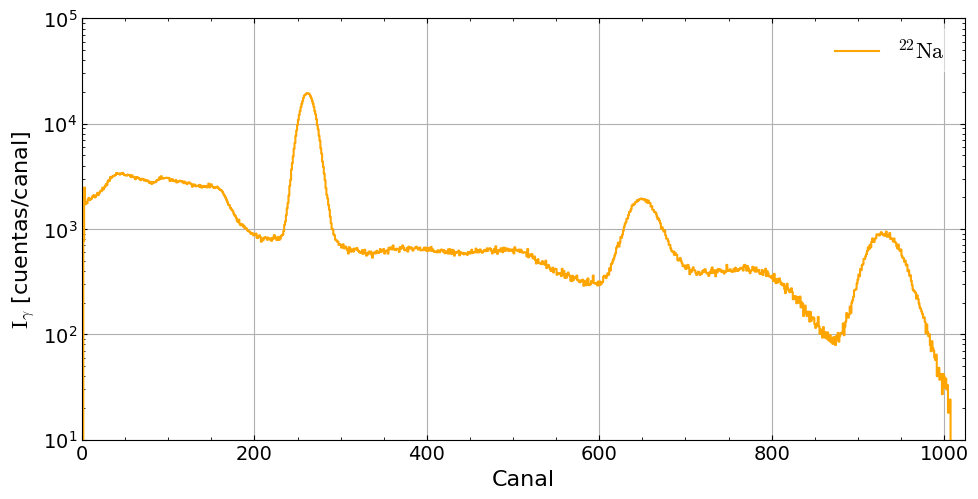

<Figure size 640x480 with 0 Axes>

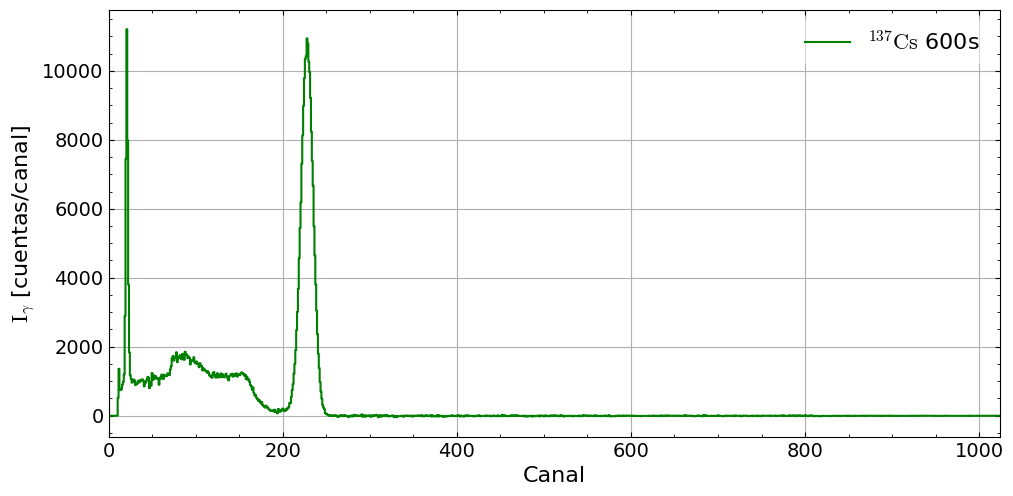


Pico:      1er pico 137Cs 600s
b0:        918 ± 23
b1:        14.065 ± 3.616
M1:        5627 ± 887
μ1:        20.92 ± 0.03
σ1:        0.91 ± 0.04
FWHM1:     2.14 ± 0.11
M2:        4772 ± 892
μ2:        21.31 ± 0.06
σ2:        1.46 ± 0.06
FWHM2:     3.43 ± 0.15
Intensidad1:      12844 ± 2121
Intensidad2:      17418 ± 3347
IntensidadT:      30262 ± 5468


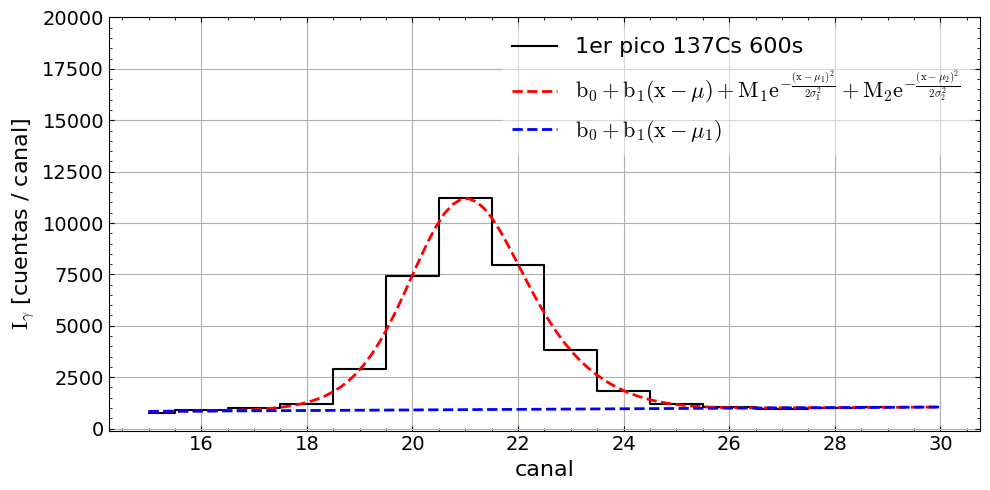


Pico:      2do pico 137Cs 600s
b0:        108 ± 13
b1:        -3.186 ± 0.380
M:         10670 ± 26
μ:         228.09 ± 0.02
σ:         6.83 ± 0.02
FWHM:      16.09 ± 0.05
Intensidad:      182714 ± 715


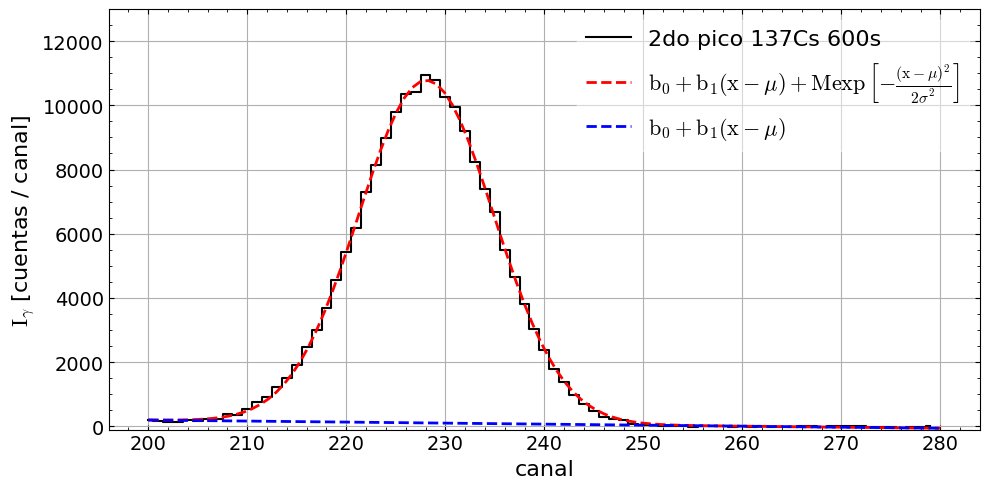


Ajuste lineal (Canal vs. Energía en keV):
a0:        4.53 ± 0.07
a1:        1.9370 ± 0.0002


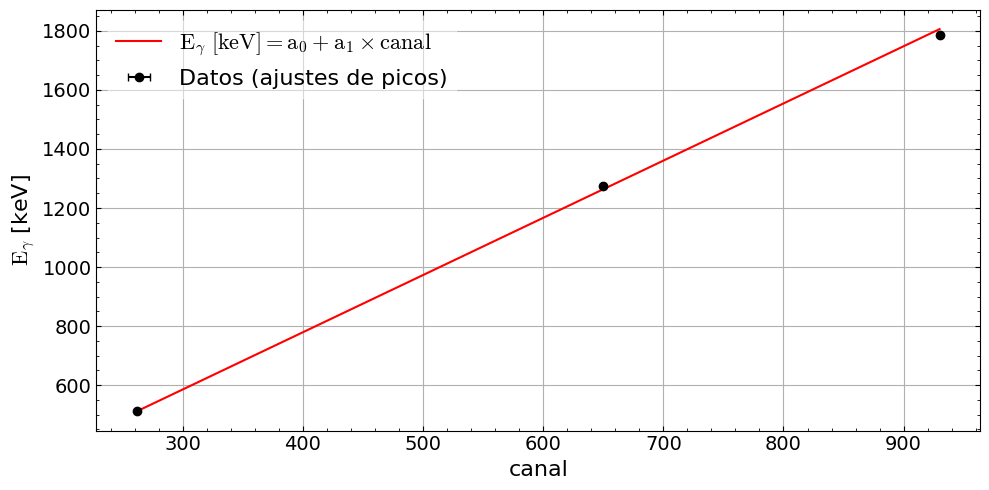

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker
from matplotlib import font_manager
import numpy as np
from scipy.optimize import curve_fit
import os
from datetime import datetime

#%% FORMATO GRAFICAS
def formato_grafico(ax=None, decimalx=None, decimaly=None, legend_loc='upper right'):
    if ax is None:
        ax = plt.gca()

    fuente = 'sans'
    ax.title.set_size(14)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    ax.title.set_family(fuente)
    ax.yaxis.label.set_family(fuente)
    ax.xaxis.label.set_family(fuente)
    ax.tick_params(axis='both', labelsize=14)

    plt.rcParams['mathtext.fontset'] = 'cm'  
    plt.rcParams['mathtext.rm'] = 'sans'  
    plt.rcParams['mathtext.default'] = 'rm'

    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

    ax.tick_params(axis='x', direction='in', which='both', bottom=True, top=True)
    ax.tick_params(axis='y', direction='in', which='both', left=True, right=True)
    ax.tick_params(axis='x', which='minor', direction='in', bottom=True, top=True)
    ax.tick_params(axis='y', which='minor', direction='in', left=True, right=True)

    if decimalx is not None:
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.{decimalx}f}' if x != 0 else '0'))
    if decimaly is not None:
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.{decimaly}f}' if x != 0 else '0'))

    if ax.get_legend() is not None:
        ax.legend(fontsize=16)

    font = font_manager.FontProperties(family='sans', style='normal', size=16)
    handles, labels = ax.get_legend_handles_labels()
    if handles and labels:
        ax.legend(loc=legend_loc, handles=handles, labels=labels,
                  edgecolor='1', framealpha=0.5, prop=font)

#%% FUNCIONES GAUSSIANA Y AJUSTES
def gauss(x, A, B, C, mu, sigma):
    return A + B * (x - mu) + C * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

def gauss_ajuste(x, y):
    media = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - media) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[1, 1, min(y), media, sigma])
    return popt, pcov

def Ajuste_gaussiano(canal, cuentas, extremo_inferior, extremo_superior,
                     a_0=0, a_1=1, unidades='canal', titulo='Ajuste Gaussiano', ylim=None):
    x = canal[extremo_inferior:extremo_superior]
    y = cuentas[extremo_inferior:extremo_superior]
    x = x * a_1 + a_0

    popt, pcov = gauss_ajuste(x, y)
    A, B, C, mu, sigma = popt

    x_ajuste = np.linspace(extremo_inferior, extremo_superior, 100) * a_1 + a_0
    y_ajuste = gauss(x_ajuste, A, B, C, mu, sigma)
    recta_ajuste = A + B * (x_ajuste - mu)

    FWHM = 2.35482 * sigma
    uncertainties = np.sqrt(np.diag(pcov))

    print("\nPico:     ", titulo)
    print("b0:        {:.0f} ± {:.0f}".format(A, uncertainties[0]))
    print("b1:        {:.3f} ± {:.3f}".format(B, uncertainties[1]))
    print("M:         {:.0f} ± {:.0f}".format(C, uncertainties[2]))
    print("μ:         {:.2f} ± {:.2f}".format(mu, uncertainties[3]))
    print("σ:         {:.2f} ± {:.2f}".format(abs(sigma), abs(uncertainties[4])))
    print("FWHM:      {:.2f} ± {:.2f}".format(abs(FWHM), abs(FWHM * (uncertainties[4] / sigma))))

    I = abs((2 * np.pi) ** 0.5 * C * sigma)
    dI = I*np.sqrt((uncertainties[2]/C)**2 + (uncertainties[4]/sigma)**2)
    print("Intensidad:      {:.0f} ± {:.0f}".format(abs(I), abs(dI)))

    plt.figure(figsize=(10, 5))
    plt.step(x, y, 'k', label='{}'.format(titulo), where='mid')
    plt.plot(x_ajuste, y_ajuste, '--r', linewidth=2,
             label=r'$b_0 + b_1 (x - \mu) + M \exp \left[-\frac{(x-\mu)^2}{2\sigma^2} \right]$')
    plt.plot(x_ajuste, recta_ajuste, '--b', linewidth=2,
             label=r'$b_0 + b_1 (x - \mu) $')
    plt.grid()
    plt.title("")
    plt.ylabel(r'$I_{\gamma}$' + ' [cuentas / canal]')
    if unidades == 'canal':
        plt.xlabel(r'canal')
    elif unidades == 'keV':
        plt.xlabel(r'$E_{\gamma}$' + ' (keV)')
    if ylim:
        plt.ylim(ylim)

    formato_grafico()
    plt.tight_layout()

    # Guardar la imagen
    save_path = r"Parcial"
    filename = f"Practica2_{titulo.replace(' ', '_')}.png"
    full_path = os.path.join(save_path, filename)
    plt.savefig(full_path, dpi=300, bbox_inches='tight')
    plt.show()

# Doble gauss
def double_gauss(x, A, B, C1, mu1, sigma1, C2, mu2, sigma2):
    return (A + B * (x - mu1) +
            C1 * np.exp(-((x - mu1) ** 2) / (2 * sigma1 ** 2)) +
            C2 * np.exp(-((x - mu2) ** 2) / (2 * sigma2 ** 2)))

def double_gauss_ajuste(x, y):
    media = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - media) ** 2) / sum(y))
    p0 = [1, 1, max(y), media - sigma, sigma, max(y)/2, media + sigma, sigma]
    popt, pcov = curve_fit(double_gauss, x, y, p0=p0)
    return popt, pcov

def Ajuste_doble_gaussiano(canal, cuentas, extremo_inferior, extremo_superior,
                           a_0=0, a_1=1, unidades='canal', titulo='Ajuste Doble Gaussiano', ylim=None):
    x = canal[extremo_inferior:extremo_superior]
    y = cuentas[extremo_inferior:extremo_superior]
    x = x * a_1 + a_0

    popt, pcov = double_gauss_ajuste(x, y)
    A, B, C1, mu1, sigma1, C2, mu2, sigma2 = popt

    x_ajuste = np.linspace(extremo_inferior, extremo_superior, 100) * a_1 + a_0
    y_ajuste = double_gauss(x_ajuste, *popt)
    recta_ajuste = A + B * (x_ajuste - mu1)

    FWHM1 = 2.35482 * sigma1
    FWHM2 = 2.35482 * sigma2
    uncertainties = np.sqrt(np.diag(pcov))

    print("\nPico:     ", titulo)
    print("b0:        {:.0f} ± {:.0f}".format(A, uncertainties[0]))
    print("b1:        {:.3f} ± {:.3f}".format(B, uncertainties[1]))
    print("M1:        {:.0f} ± {:.0f}".format(C1, uncertainties[2]))
    print("μ1:        {:.2f} ± {:.2f}".format(mu1, uncertainties[3]))
    print("σ1:        {:.2f} ± {:.2f}".format(abs(sigma1), abs(uncertainties[4])))
    print("FWHM1:     {:.2f} ± {:.2f}".format(abs(FWHM1), abs(FWHM1 * (uncertainties[4] / sigma1))))
    print("M2:        {:.0f} ± {:.0f}".format(C2, uncertainties[5]))
    print("μ2:        {:.2f} ± {:.2f}".format(mu2, uncertainties[6]))
    print("σ2:        {:.2f} ± {:.2f}".format(abs(sigma2), abs(uncertainties[7])))
    print("FWHM2:     {:.2f} ± {:.2f}".format(abs(FWHM2), abs(FWHM2 * (uncertainties[7] / sigma2))))

    I1 = abs((2 * np.pi) ** 0.5 * C1 * sigma1)
    dI1 = I1 * np.sqrt((uncertainties[2]/C1)**2 + (uncertainties[4]/sigma1)**2)
    I2 = abs((2 * np.pi) ** 0.5 * C2 * sigma2)
    dI2 = I2 * np.sqrt((uncertainties[5]/C2)**2 + (uncertainties[7]/sigma2)**2)

    print("Intensidad1:      {:.0f} ± {:.0f}".format(abs(I1), abs(dI1)))
    print("Intensidad2:      {:.0f} ± {:.0f}".format(abs(I2), abs(dI2)))
    print("IntensidadT:      {:.0f} ± {:.0f}".format(abs(I1+I2), abs(dI1+dI2)))

    plt.figure(figsize=(10, 5))
    plt.step(x, y, 'k', label='{}'.format(titulo), where='mid')
    plt.plot(x_ajuste, y_ajuste, '--r', linewidth=2,
             label=(r'$b_0 + b_1 (x - \mu) + M_1 e^{-\frac{(x-\mu_1)^2}{2\sigma_1^2}} + '
                    r'M_2 e^{-\frac{(x-\mu_2)^2}{2\sigma_2^2}}$'))
    plt.plot(x_ajuste, recta_ajuste, '--b', linewidth=2,
             label=r'$b_0 + b_1 (x - \mu_1) $')
    plt.grid()
    plt.ylabel(r'$I_{\gamma}$' + ' [cuentas / canal]')
    if unidades == 'canal':
        plt.xlabel(r'canal')
    elif unidades == 'keV':
        plt.xlabel(r'$E_{\gamma}$ [keV]')
    if ylim:
        plt.ylim(ylim)

    formato_grafico()
    plt.tight_layout()

    # Guardar la imagen
    save_path = r"Parcial"
    filename = f"Practica2_{titulo.replace(' ', '_')}.png"
    full_path = os.path.join(save_path, filename)
    plt.savefig(full_path, dpi=300, bbox_inches='tight')
    plt.show()

# Triple gauss
def triple_gauss(x, A, B, C1, mu1, sigma1, C2, mu2, sigma2, C3, mu3, sigma3):
    return (A + B * (x - mu1) +
            C1 * np.exp(-((x - mu1) ** 2) / (2 * sigma1 ** 2)) +
            C2 * np.exp(-((x - mu2) ** 2) / (2 * sigma2 ** 2)) +
            C3 * np.exp(-((x - mu3) ** 2) / (2 * sigma3 ** 2)))

def triple_gauss_ajuste(x, y, mu1, mu2, mu3):
    sigma = np.sqrt(sum(y * (x - mu1) ** 2) / sum(y))
    p0 = [1, 1, max(y), mu1, sigma, max(y)/2, mu2, sigma, max(y)/3, mu3, sigma]
    popt, pcov = curve_fit(triple_gauss, x, y, p0=p0)
    return popt, pcov

def Ajuste_triple_gaussiano(canal, cuentas, extremo_inferior, extremo_superior,
                            mu1, mu2, mu3, a_0=0, a_1=1, unidades='canal',
                            titulo='Ajuste Triple Gaussiano', ylim=None):
    x = canal[extremo_inferior:extremo_superior]
    y = cuentas[extremo_inferior:extremo_superior]
    x = x * a_1 + a_0

    popt, pcov = triple_gauss_ajuste(x, y, mu1, mu2, mu3)
    A, B, C1, mu1, sigma1, C2, mu2, sigma2, C3, mu3, sigma3 = popt

    x_ajuste = np.linspace(extremo_inferior, extremo_superior, 100) * a_1 + a_0
    y_ajuste = triple_gauss(x_ajuste, *popt)
    recta_ajuste = A + B * (x_ajuste - mu1)

    FWHM1 = 2.35482 * sigma1
    FWHM2 = 2.35482 * sigma2
    FWHM3 = 2.35482 * sigma3
    uncertainties = np.sqrt(np.diag(pcov))

    print(f"\nPico: {titulo}")
    print("b0:        {:.0f} ± {:.0f}".format(A, uncertainties[0]))
    print("b1:        {:.3f} ± {:.3f}".format(B, uncertainties[1]))

    # Para M1, μ1, σ1 => índices [2,3,4]; M2, μ2, σ2 => [5,6,7]; M3, μ3, σ3 => [8,9,10]
    for i, (C, mu, sigma, FWHM) in enumerate([
        (C1, mu1, sigma1, FWHM1),
        (C2, mu2, sigma2, FWHM2),
        (C3, mu3, sigma3, FWHM3)
    ], start=1):
        idx = 2*(i)  # 'i' in [1..3], but the indexing is 2*(i)+something? We'll just separate them carefully.
        print(f"M{i}: {C:.0f} ± {uncertainties[2*i]:.0f}")
        print(f"μ{i}: {mu:.2f} ± {uncertainties[2*i+1]:.2f}")
        print(f"σ{i}: {sigma:.2f} ± {uncertainties[2*i+2]:.2f}")
        print(f"FWHM{i}: {FWHM:.2f} ± {FWHM * (uncertainties[2*i+2] / sigma):.2f}")

    I = [
        abs((2 * np.pi) ** 0.5 * C1 * sigma1),
        abs((2 * np.pi) ** 0.5 * C2 * sigma2),
        abs((2 * np.pi) ** 0.5 * C3 * sigma3)
    ]
    dI = [
        I[0] * np.sqrt((uncertainties[2] / C1)**2 + (uncertainties[4]/sigma1)**2),
        I[1] * np.sqrt((uncertainties[5] / C2)**2 + (uncertainties[7]/sigma2)**2),
        I[2] * np.sqrt((uncertainties[8] / C3)**2 + (uncertainties[10]/sigma3)**2)
    ]

    for i in range(3):
        print(f"Intensidad{i+1}: {I[i]:.0f} ± {dI[i]:.0f}")
    print(f"IntensidadT: {sum(I):.0f} ± {sum(dI):.0f}")

    plt.figure(figsize=(10, 5))
    plt.step(x, y, 'k', label='{}'.format(titulo), where='mid')
    plt.plot(x_ajuste, y_ajuste, '--r', linewidth=2,
             label=(r'$b_0 + b_1 (x - \mu) + M_1 e^{-\frac{(x-\mu_1)^2}{2\sigma_1^2}} +'
                    r' M_2 e^{-\frac{(x-\mu_2)^2}{2\sigma_2^2}} +'
                    r' M_3 e^{-\frac{(x-\mu_3)^2}{2\sigma_3^2}}$'))
    plt.plot(x_ajuste, recta_ajuste, '--b', linewidth=2,
             label=r'$b_0 + b_1 (x - \mu_1) $')
    plt.grid()
    plt.ylabel(r'$I_{\gamma}$' + ' [cuentas / canal]')
    if unidades == 'canal':
        plt.xlabel(r'canal')
    elif unidades == 'keV':
        plt.xlabel(r'$E_{\gamma}$ [keV]')
    if ylim:
        plt.ylim(ylim)

    formato_grafico()
    plt.tight_layout()

    save_path = r"Parcial"
    filename = f"Practica2_{titulo.replace(' ', '_')}.png"
    full_path = os.path.join(save_path, filename)
    plt.savefig(full_path, dpi=300, bbox_inches='tight')
    plt.show()

#%% FUNCION PARA CARGAR DATOS
def cargar_datos(ruta):
    return pd.read_csv(ruta, sep=r'\s+', skiprows=1, names=["canal", "cuentas"])

#%% RUTAS (Informe2/Data)
ruta_137Cs  = r"Parcial/137Cs-previa2.dat"
ruta_na22  = r"Parcial/22Na-previa2.csv"
ruta_fondo  = r"Parcial/fondo-previa2.dat"


#%% CARGAR DATOS
datos_na22  = pd.read_csv(ruta_na22)
#%datos_22Na     = cargar_datos(ruta_22Na)
datos_137Cs    = cargar_datos(ruta_137Cs)
datos_Fondo = cargar_datos(ruta_fondo)

# Acceder a las columnas
canal_na22    = datos_na22['canal']
cuentas_na22  = datos_na22['cuentas']


#%% GRAFICAS CON FONDO
plt.figure(figsize=(10, 5))
plt.step(canal_na22, cuentas_na22,   'orange',    label=r'$^{22}\text{Na}$', where='mid')
#%plt.step(datos_137Cs["canal"],  datos_137Cs["cuentas"],  'green',     label=r'$^{137}\text{Cs}$ 600s', where='mid')
#%plt.step(datos_Fondo["canal"], datos_Fondo["cuentas"], 'darkviolet', label='Fondo', where='mid')


plt.xlim([0, 1024])
plt.ylim([10, 100000])
plt.xlabel(r'Canal')
plt.ylabel(r'$I_{\gamma}$ [cuentas/canal]')
plt.legend()
plt.tight_layout()
plt.grid()
formato_grafico()
plt.yscale('log')
save_path = r"Parcial"
filename = "Graficatotal22Na.png"
full_path = os.path.join(save_path, filename)
plt.savefig(full_path, dpi=300, bbox_inches='tight')
plt.show()

#%% Comparación por subplots


plt.tight_layout()
filename = "Practica2_Patrones_Separados.png"
full_path = os.path.join(save_path, filename)
plt.savefig(full_path, dpi=300, bbox_inches='tight')
plt.show()


#%% GRAFICAS SIN FONDO
#datos_22Na["cuentas"]  -= datos_Fondo["cuentas"]
datos_137Cs["cuentas"] -= datos_Fondo["cuentas"]

plt.figure(figsize=(10, 5))
#plt.step(datos_22Na["canal"],  datos_22Na["cuentas"],  'orange', label=r'$^{22}\text{Na}$ 600s', where='mid')
plt.step(datos_137Cs["canal"], datos_137Cs["cuentas"], 'green',  label=r'$^{137}\text{Cs}$ 600s', where='mid')

plt.xlim([0, 1024])
plt.xlabel(r'Canal')
plt.ylabel(r'$I_{\gamma}$ [cuentas/canal]')
plt.tight_layout()
formato_grafico()
plt.grid()

filename = "EspectroCs137.png"
full_path = os.path.join(save_path, filename)
plt.savefig(full_path, dpi=300, bbox_inches='tight')
plt.show()


#%% Ajuste Picos
Ajuste_doble_gaussiano(datos_137Cs["canal"], datos_137Cs["cuentas"],
                       extremo_inferior=15, extremo_superior=30,
                       unidades='canal', titulo=r'1er pico 137Cs 600s',
                       ylim = [-100,20000])

Ajuste_gaussiano(datos_137Cs["canal"], datos_137Cs["cuentas"],
                 extremo_inferior=200, extremo_superior=280,
                 unidades='canal', titulo=r'2do pico 137Cs 600s',
                 ylim = [-100,13000])

#%% Ajuste Canal vs. Energía (calibración)
E_gamma_keV = np.array([511, 1274.5, 1785.5])
E_gamma_canal = np.array([261.54, 649.74, 929.94])
dE_gamma_canal = np.array([0.02, 0.12, 0.21])
fwhm_canal = [2.88, 6.80, 7.35, 13.60, 16.09, 20.81, 23.37, 22.23]
dfwhm_canal = np.array([0.06, 0.11, 0.08, 0.15, 0.05, 0.19, 0.49, 0.24])

def linear(x, a, b):
    return a + b*x

popt, pcov = curve_fit(linear, E_gamma_canal, E_gamma_keV,
                       sigma=dE_gamma_canal, absolute_sigma=True)
a, b = popt
uncertainties = np.sqrt(np.diag(pcov))

x_fit = np.linspace(min(E_gamma_canal), max(E_gamma_canal), 100)
y_fit = linear(x_fit, *popt)

print("\nAjuste lineal (Canal vs. Energía en keV):")
print("a0:        {:.2f} ± {:.2f}".format(a, uncertainties[0]))
print("a1:        {:.4f} ± {:.4f}".format(b, uncertainties[1]))

fig, ax = plt.subplots(figsize=(10, 5))
ax.errorbar(E_gamma_canal, E_gamma_keV, xerr=dE_gamma_canal,
            fmt='o', label="Datos (ajustes de picos)", color='k', capsize=3)
ax.plot(x_fit, y_fit, '-r', label=r"$E_{\gamma} \ [keV] = a_0 + a_1 \times canal$")
ax.set_ylabel(r'$E_{\gamma}$ [keV]')
ax.set_xlabel('canal')
ax.grid()

formato_grafico(legend_loc='upper left')
plt.tight_layout()

filename = "Practica2_Calibracion.png"
full_path = os.path.join(save_path, filename)
plt.savefig(full_path, dpi=300, bbox_inches='tight')
plt.show()

E_gamma_ajuste = linear(E_gamma_canal, *popt)
delta = E_gamma_keV - E_gamma_ajuste
percent_error = (delta / E_gamma_keV) * 100

dE_gamma_ajuste = np.sqrt((uncertainties[0])**2 + (uncertainties[1]*E_gamma_canal)**2)
d_delta = dE_gamma_ajuste
d_percent_error = (d_delta / E_gamma_keV) * 100


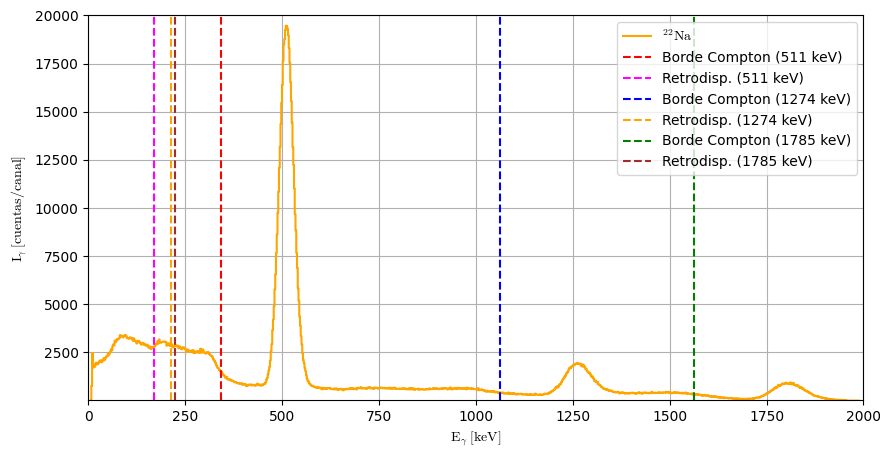

In [28]:
#%% CARGAR DATOS
datos_na22  = pd.read_csv(ruta_na22)
#%datos_22Na     = cargar_datos(ruta_22Na)
datos_137Cs    = cargar_datos(ruta_137Cs)
datos_Fondo = cargar_datos(ruta_fondo)

# Acceder a las columnas
canal_na22    = datos_na22['canal']
cuentas_na22  = datos_na22['cuentas']

Energia_na22 = 4.53 + 1.937*canal_na22

#%% GRAFICAS CON FONDO
plt.figure(figsize=(10, 5))
plt.step(Energia_na22, cuentas_na22,   'orange',    label=r'$^{22}\text{Na}$', where='mid')
#%plt.step(datos_137Cs["canal"],  datos_137Cs["cuentas"],  'green',     label=r'$^{137}\text{Cs}$ 600s', where='mid')
#%plt.step(datos_Fondo["canal"], datos_Fondo["cuentas"], 'darkviolet', label='Fondo', where='mid')



# Información de los tres picos: energía pico, borde Compton (compton) y retro (retro)
peak_info = [
    {"peak": 511,  "compton": 341,  "retro": 170},
    {"peak": 1274, "compton": 1061, "retro": 213},
    {"peak": 1785, "compton": 1562, "retro": 223},
]

# Colores distintos para borde Compton y retro en cada pico.
# (Estos son solo ejemplos; puedes elegir los que prefieras)
compton_colors = ["red", "blue", "green"]
retro_colors   = ["magenta", "orange", "brown"]

# Supongamos que ya trazaste tu espectro y configuraste tus ejes
# Aquí ajustamos los límites y etiquetas
plt.xlim([0, 2000])
plt.ylim([10, 20000])
plt.xlabel(r'$E_{\gamma} \;[\text{keV}]$')
plt.ylabel(r'$I_{\gamma} \;[\text{cuentas/canal}]$')

# Agregamos líneas verticales para cada borde Compton y retrodisp.
for i, p in enumerate(peak_info):
    # Borde Compton
    plt.axvline(
        x=p["compton"],
        color=compton_colors[i],
        linestyle='--',
        label=f"Borde Compton ({p['peak']} keV)"
    )
    # Retrodispersión
    plt.axvline(
        x=p["retro"],
        color=retro_colors[i],
        linestyle='--',
        label=f"Retrodisp. ({p['peak']} keV)"
    )

plt.legend()
plt.grid()

def formato_grafico():
    # Si tienes un estilo de gráfico adicional, puedes definirlo aquí.
    pass

formato_grafico()

save_path = r"Parcial"
filename = "Comptonyretro.png"
full_path = os.path.join(save_path, filename)

plt.savefig(full_path, dpi=300, bbox_inches='tight')
plt.show()